In [1]:
# Import the neccesary libraries for the model
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from skimage.color import rgb2gray
from skimage.transform import resize

import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

import itertools
import matplotlib.pyplot as plt

SEED = 300

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

Step 1: Define the problem and collect samples and labels

Step 2: Choose the success criterion and monitoring metrics

Step 3: Choose validation protocol (hold-out)

Step 4: Prepare data

Step 5: Develop first underfitting model with stat power

Step 6: Develop larger overfitting model

Step 7: Regularise the overfitting model and tune hyperparameters based on performance on validation data

Retrain with entire training set and evaluate on the unseen test set

## Defining the problem

The dataset I am using has images of horses and humans. The objective of this dataset is to create a model that can predict correctly if the image is a horse or a human. This problem is called a Binary Image classification as there are two different classes to identify the image either a human or a horse. The dataset is taken from tensorflow datasets https://www.tensorflow.org/datasets/catalog/horses_or_humans.

The dataset contains the images and labels.
(Describe the data size)

In [2]:
DATASET = 'cats_vs_dogs'
RESIZE = (30,30,3)
GRAY_SCALE = True

In [3]:
ds = tfds.load(DATASET, split='all', shuffle_files=True)
images, labels = [], []
for entry in ds.take(len(ds)) :
    image, label = entry['image'], entry['label']
    
    image, label = image.numpy(), label.numpy()
    
    image = resize(image, RESIZE, anti_aliasing=True)
            
    if GRAY_SCALE :
        image = rgb2gray(image)
        
    images.append( image )
    labels.append( label )

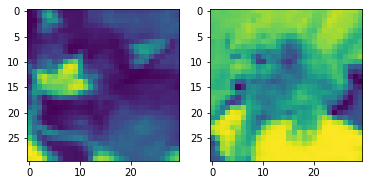

In [4]:
plt.subplot(1,2,1)
plt.imshow(images[1])

plt.subplot(1,2,2)
plt.imshow(images[3])


## Preparing data

Firstly, we have to flatten the 2D image array into a 1D array. Then we initialise the X (data) and Y(labels).

In [5]:
X = np.array(images)
X = X.reshape( (X.shape[0], -1) )
y = np.array(labels)

Secondly, we split the data into training and test sets. The size of the test sets is 10% of the whole data. 

In [6]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, 
                                                    random_state=SEED, shuffle=True)

The pixels are normalised to be between 0 and 1 from 0 and 255

In [7]:
# normalise pixels from [0, 255] to [0, 1]
X_train, X_test = X_train/255, X_test/255

## Measure of Success

I will be using the baseline to determine the success of the model. If the model has a higher score than the baseline, the model is a success.

The baseline is the estimated probability that the model will predict the correct label. It is derived from taking the number of label of one class and dividing it with the total number of labels.

There are only two classes and since the number of every labels are nearly the same, we can conclude that this is a balanced class.

Based on the calculations below, the baseline accuracy is about 0.5
Therefore, to consider the model a success, it has to have a higher than 0.5 accuracy.

In [8]:
len(y)

23262

In [9]:
np.sum(y), len(y)-np.sum(y)
baseline = (len(y)-np.sum(y)) / len(y)
balanced_baseline = balanced_accuracy_score(y_train, np.ones(len(y_train)))
balanced_baseline

0.5

## Validation protocol
For validation protocol, I have chosen a hold-out validation set method. The reason is because there is enough data to work with for the training and test sets.

In [10]:
val_size = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size=val_size, stratify=y_train,
                                                 shuffle=True, random_state=SEED)

In [11]:
X_test.shape

(4653, 900)

## Developing a model that does better than the baseline

To develop a model, there are three key decisions to make. Firstly, the last-layer activation. Secondly, the loss function and lastly, the optimization configuration.

In the case of this model, the last layer activation that will be used is relu and the loss function is binary_crossentropy as it is a binary classification problem. For the optimization configuration, rmsprop will be used.

The code below constructs a neural network based on the user inputs. With this, one does not have to manually create a model but just input the variables to construct the desired model.

In [12]:
def custom_network(hidden_layers=0, hidden_neurons=np.nan, activation=None,
                        dropout=np.nan, input_dimension=2, output_dimension=1,
                        optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'],
                        name=None) :
    
    model = Sequential()
    for i in range(hidden_layers) :
        model.add(Dense(hidden_neurons, 
                  activation=activation,
                  input_shape='default' if i>1 else (input_dimension,)))
        if ~np.isnan(dropout) :
            model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension,
                    activation='sigmoid' if output_dimension==1 else 'softmax',
                    input_shape='default' if hidden_layers>0 else (input_dimension,)))
  
    if name is not None :
        model._name = name
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

This code trains the neural network that was constructed based on the user inputs.

In [13]:
# Fitting MLP Classification Model
def train_custom_network(model, X, y,
                              batch_size=32, epochs=100, 
                              val_data=None, callbacks=[], seed=0) :
    
    #if val_data is None :
        #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                          #random_state=seed, shuffle=True, 
                                                          #stratify=y)
        
    
    X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
  

    history = model.fit(X_train, y_train,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val, verbose=0)[1:], 
            'history': history }

The function below helps to plot the training and validation loss

In [14]:
def plot_trainval_loss(history, monitors=['loss', 'AUC']) :

  # using the variable axs for multiple Axes
  fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15,5))
 
  for ax, monitor in zip(axs.flat, monitors) :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
      monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    ax.plot(epochs, loss, 'b.', label=monitor)
    ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Validation ' + monitor)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

  _ = plt.show()

To develop a model that does better than the baseline, a model with a single layer should be more than sufficient to achieve an accuracy more than the baseline of 0.5. Thus, a single layer perceptron is suitable for this.

Single layer perceptron is a simple neural network that can classify only linear seperable problems that has a binary classes of zeros and ones[1].
Ref [1] from https://www.saedsayad.com/artificial_neural_network_bkp.htm#:~:text=A%20single%20layer%20perceptron%20(SLP,target%20(1%20%2C%200).

In [15]:
input_d = X_train.shape[1]
output_d = 1

OPTIMIZER = 'RMSprop'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

In [16]:
learn_rate = 0.004

underfit_model = custom_network(hidden_layers=0, hidden_neurons=64,
                                activation='sigmoid',
                                input_dimension=input_d, output_dimension=output_d,
                                optimizer=RMSprop(learning_rate=learn_rate), 
                                metrics=METRICS,
                                name='Underfitting_Model')

underfit_model.summary()

Model: "Underfitting_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 901       
                                                                 
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________


In [17]:
batch_size = 128
EPOCHS = 500

MONITOR = 'val_loss'
PATIENCE = 10

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, 
                           patience=PATIENCE, verbose=0)

In [18]:
trained_underfit_model = train_custom_network(underfit_model, X_train, y_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

In [19]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_underfit_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_underfit_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_underfit_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_underfit_model['val_score'][3]))

Accuracy (Validation): 0.58 (baseline=0.50)
Precision (Validation): 0.58
Recall (Validation): 0.58
AUC (Validation): 0.61


The underfitting model has an accuracy of 0.55 when used to test on the validation data. This shows that the model is successful in achieving an accuracy that is higher than the baseline of 0.5 despite it being a single layer model. 

In [20]:
preds = trained_underfit_model['model'].predict(X_val, verbose=0)

print('Balanced Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(balanced_accuracy_score(y_val, (preds > 0.5).astype('int32')), balanced_baseline))

Balanced Accuracy (Validation): 0.58 (baseline=0.50)


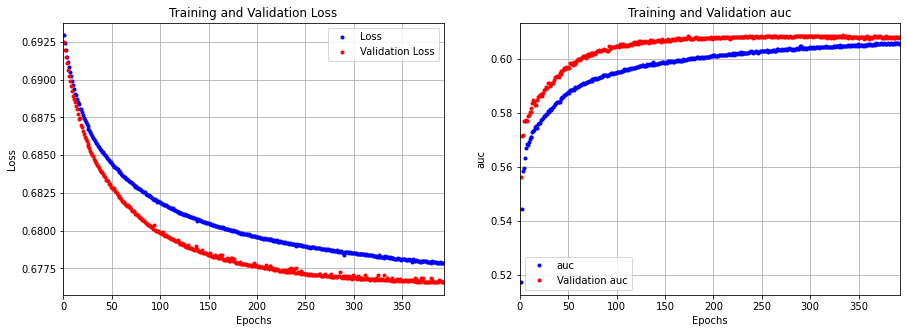

In [21]:
plot_trainval_loss(trained_underfit_model['history'], monitors=['loss', 'auc'])

## Developing an overfitting model
To construct an overfitting model, we would have to add more layers into the model, increase the number of layers and train the model for even longer epochs.

In [22]:
learn_rate = 0.004

overfit_model = custom_network(hidden_layers=2, hidden_neurons=64,
                                activation='relu',
                                input_dimension=input_d, output_dimension=output_d,
                                optimizer=RMSprop(learning_rate=learn_rate), 
                                loss=LOSS, metrics=METRICS,
                                name='Overfitting_Model')

overfit_model.summary()

Model: "Overfitting_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                57664     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 61,889
Trainable params: 61,889
Non-trainable params: 0
_________________________________________________________________


In [23]:
trained_overfit_model = train_custom_network(overfit_model, X_train, y_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[], seed=SEED)

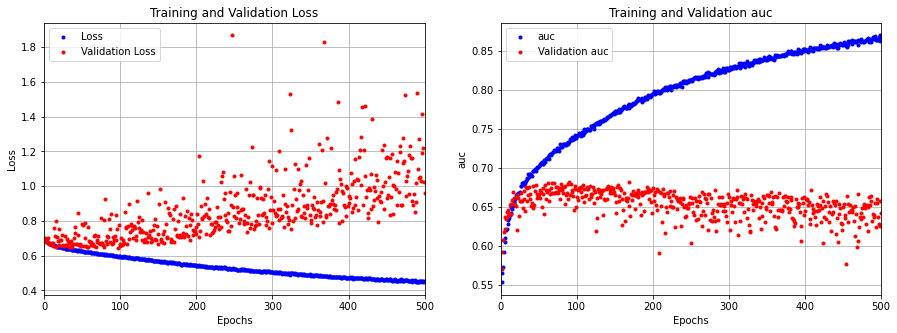

In [24]:
plot_trainval_loss(trained_overfit_model['history'], monitors=['loss', 'auc'])

In [25]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_overfit_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_overfit_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_overfit_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_overfit_model['val_score'][3]))

Accuracy (Validation): 0.60 (baseline=0.50)
Precision (Validation): 0.59
Recall (Validation): 0.69
AUC (Validation): 0.64


## Regularise the overfitting model and tune hyperparameters based on performance on validation data

Using the overfitted model, we will regularlise it and tune the hyperparameters to achieve the optimum model. There are various methods to tune the model and they are, adding droput, adding L1 and L2 regularization, try removing or adding layers, trying various hyperparameters to achieve the satisfied result.

I will be using grid search cross validation method to find the desired parameters from the various different parameters in the grid. With this, one does not have to try and error, inputting many different parameters manually to achieve the optimal model which can be very time consuming. Instead, the grid search cross validation method will produce a table of parameters displaying their results which I can choose from to achieve the optimal model.

The regularization method I will use is the dropout method. A dropout layer will be added into the model. The reason why the dropout method is chosen is because it is simple and effective to implement. It helps to reduce the overfitting. In addition to this, reducing the learning rate will also help reduce the overfitting.

Dataframe_format is a helper function which will help to format the results from the grid search into a dataframe which makes it easier to read the data.

In [26]:
def dataframe_format(stats, mapping) :
    entries = []
    for param, metrics in stats.items() :
        entry = eval(param)
        for key, value in metrics.items() :
            entry[key] = value
        
        for key, value in mapping.items() :
            entry[value] = entry['scores'][key]
            
        entry.pop('scores') 
        
        entries.append( entry )

    return pd.DataFrame(data=entries)

grid_search is a function which will run a grid search on the model finding the best parameters for an optimal model

In [31]:
def grid_search(X, y,
                   space, cv, 
                   learning_rate, loss, metrics, 
                   epochs, callbacks=[], seed=0, 
                   order={}) :
    
    keys, values = zip(*space.items())
    
    stats = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
        kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
        
        scores, stopped, losses = [], [], []
        for train, validate in kfold.split(X, y) :
            model = custom_network(hidden_layers=params['hidden_layers'], 
                                        hidden_neurons=params['neurons'], 
                                        activation=params['activation'], 
                                        dropout=params['dropout'], 
                                        input_dimension=X.shape[1], 
                                        output_dimension=1 if len(y.shape)<2 else y.shape[1],
                                        optimizer=RMSprop(learning_rate=learn_rate), 
                                        loss=loss, metrics=metrics)
      
            trained = train_custom_network(model, 
                                                X[train,:], y[train],
                                                batch_size=params['batch_size'], epochs=epochs, 
                                                val_data=(X[validate,:], y[validate]), 
                                                callbacks=callbacks, seed=seed) 
            
            evaluations = trained['model'].evaluate(X[validate,:], y[validate], verbose=0)[1:]
                        
            scores.append( evaluations )
            stopped.append( len(trained['history'].history['val_loss']) )
            losses.append( np.min(trained['history'].history['val_loss']) )
        
        stats[str(params)] = { 'scores': np.mean(scores, axis=0), 
                               'epochs': np.mean(stopped), 
                               'val_loss': np.mean(losses) }
    
    return dataframe_format(stats, order)

In [32]:
orders = {
    0: 'accuracy',              
    1: 'precision',
    2: 'recall',
    3: 'auc',
}

In [33]:
KFOLDS = 5

In [43]:
params = {
    'hidden_layers': [1, 2, 3],
    'neurons': [64],
    'activation': ['relu'],
    'dropout': [0.2],
    'batch_size': [128]
}

learn_rate = 0.002
epochs = 500

stats = grid_search(X_train, y_train,  
                       space=params, cv=KFOLDS, 
                       learning_rate=learn_rate, 
                       loss=LOSS, metrics=METRICS, 
                       epochs=epochs, callbacks=[EARLY_STOP], seed=SEED,
                       order=orders)

In [44]:
stats.sort_values(by=['auc'], ascending=False)

,hidden_layers,neurons,activation,dropout,batch_size,epochs,val_loss,accuracy,precision,recall,auc
1,2,64,relu,0.2,128,49.2,0.653766,0.611922,0.600326,0.672233,0.657180
2,3,64,relu,0.2,128,56.8,0.654660,0.615863,0.607680,0.659878,0.656678
0,1,64,relu,0.2,128,107.0,0.656617,0.608053,0.592223,0.688875,0.649954


In [51]:
opt_model = custom_network(hidden_layers=2, hidden_neurons=64,
                                dropout=0.2, activation='relu',
                                input_dimension=input_d, output_dimension=output_d,
                                optimizer=RMSprop(learning_rate=learn_rate), 
                                loss=LOSS, metrics=METRICS,
                                name='Optimal_Model')

opt_model.summary()

Model: "Optimal_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_127 (Dense)           (None, 64)                57664     
                                                                 
 dropout_81 (Dropout)        (None, 64)                0         
                                                                 
 dense_128 (Dense)           (None, 64)                4160      
                                                                 
 dropout_82 (Dropout)        (None, 64)                0         
                                                                 
 dense_129 (Dense)           (None, 1)                 65        
                                                                 
Total params: 61,889
Trainable params: 61,889
Non-trainable params: 0
_________________________________________________________________


In [52]:
trained_opt_model = train_custom_network(opt_model, X_train, y_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

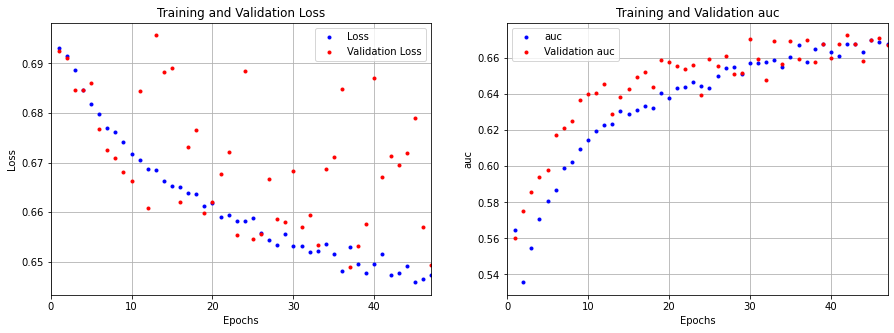

In [57]:
plot_trainval_loss(trained_opt_model['history'], monitors=['loss', 'auc'])

In [58]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_opt_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_opt_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_opt_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_opt_model['val_score'][3]))

Accuracy (Validation): 0.62 (baseline=0.50)
Precision (Validation): 0.61
Recall (Validation): 0.67
AUC (Validation): 0.67


In [59]:
preds = trained_opt_model['model'].predict(X_test, verbose=0)

print('Accuracy (Test): {:.2f} (baseline={:.2f})'.format(accuracy_score(y_test, (preds > 0.5).astype('int32')), baseline))
print('Precision (Test): {:.2f}'.format(precision_score(y_test, (preds > 0.5).astype('int32'))))
print('Recall (Test): {:.2f}'.format(recall_score(y_test, (preds > 0.5).astype('int32'))))
print('AUC (Test): {:.2f}'.format(roc_auc_score(y_test, preds)))

Accuracy (Test): 0.62 (baseline=0.50)
Precision (Test): 0.62
Recall (Test): 0.65
AUC (Test): 0.67


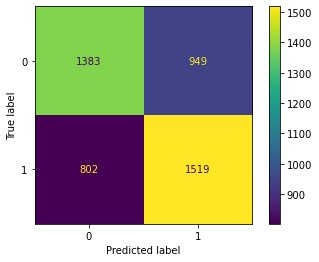

In [60]:
disp = ConfusionMatrixDisplay( confusion_matrix(y_test, (preds > 0.5).astype('int32')) )
_ = disp.plot()

## Summary
From the results above, it shows that the model is successful as it has a higher accuracy than the baseline score. 

The optimal model is made up of three layers consisting of two dense layers with 64 neurons and a dense layer with a single neuron. It also has two dropout layers which helps to prevent the model from overfitting. 



### Things to do
- Adjust the learning rate
- Tweak the variable names
- Comment more on the results
- Understand more of the model